# PINN RNN POD reduction

In [1]:
import numpy as np
# import pandas as pd
# from scipy import sparse
# from scipy.sparse import csr_matrix
import time
import datetime
import sys
import os
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
# from matplotlib import colormaps
# import random
import json
import seaborn as sns

import sklearn
# from sklearn.metrics import root_mean_squared_error
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()
# print(dir_path)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from plot_functions import *

sys.path.append('../Convolutional_NN') 

from Dataset_Class import *

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Configuración global de Matplotlib

In [2]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [4]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

<a id='section_1'></a>
# PCB solver trasient

In [5]:
sys.path.append('../scripts') 

from PCB_solver_tr import PCB_solver_main, PCB_case_1, PCB_case_2

# Dataset import

Dataset hyperparameters

In [6]:
n_train = 100
n_test = 10
n_val = 20
time_sim = 100 # seconds

sequence_length = time_sim+1 # seconds
dt = 1 # seconds
T_init = 298.0 # Kelvin
nodes_side = 13 # number of nodes in one side of the PCB

Dataset extraction

In [7]:
dataset = load_dataset(base_path=dir_path)  # ← carga el dataset base completo (PCB_transient_dataset.pth)
dataset_train = load_trimmed_dataset(base_path=dir_path, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length)
dataset_test = load_trimmed_dataset(base_path=dir_path, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length)
dataset_val = load_trimmed_dataset(base_path=dir_path, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length)

input_train, output_train = prepare_data_for_convlstm(dataset_train, device=device)
input_test, output_test = prepare_data_for_convlstm(dataset_test, device=device)
input_val, output_val = prepare_data_for_convlstm(dataset_val, device=device)

train_loader = DataLoader(TensorDataset(input_train, output_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(input_test, output_test), batch_size=32, shuffle=False)
val_loader = DataLoader(TensorDataset(input_val, output_val), batch_size=32, shuffle=False)

✅ Cargando dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_p

✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_test.pth
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_val.pth
[DEBUG] x: torch.Size([100, 101, 3, 13, 13]), y: torch.Size([100, 101, 1, 13, 13])
[DEBUG] x: torch.Size([10, 101, 3, 13, 13]), y: torch.Size([10, 101, 1, 13, 13])
[DEBUG] x: torch.Size([20, 101, 3, 13, 13]), y: torch.Size([20, 101, 1, 13, 13])


Dataset parameters: variable max and min values, number of data, boundary conditions...

In [8]:
# n_train_cases = [100, 500, 1000]
# n_test_cases = [case // 10 for case in n_train_cases]
# n_validation = [case // 50 for case in n_train_cases]

# nodes_side = 13
# dt = 1
# T_init = 298.0

# n_data = n_train+n_test+n_validation

# input = []
# output = []

# np.random.seed(0)

# Q_random = np.random.uniform(0.1, 1.25, (n_data, 4))
# T_interfaces_random = np.random.uniform(260, 310, (n_data, 4))
# T_env_random = np.random.uniform(260, 310, n_data)

Iterating to get the full dataset

In [9]:
# time_start = time.time()

# for i in range(n_data):
    
#     # Print iteration number
#     if i%100 == 0:
#         print("Generating element number: ",i)
        
#     # Generate the data
#     T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_random[i], T_interfaces = T_interfaces_random[i], Tenv = T_env_random[i]) # heaters in default position
#     # T = T.reshape(T.shape[0], nodes_side,nodes_side) # reshaping the data grid-shape
    
#     # Append the data to the list
#     output.append(T)
#     input1 = []
#     # print(T_interfaces_random[i],Q_random[i],T_env_random[i]) # DEBUGGING
#     input1 = np.concatenate((T_interfaces_random[i],Q_random[i],[T_env_random[i]]),axis=0)
#     # print(input1) # DEBUGGING
#     input.append(input1)
    
# time_end = time.time()
# time_generation_data = time_end-time_start
# print("Time to generate the data: ",time_generation_data)

# # transform the lists into numpy arrays
# input = np.array(input)
# output = np.array(output)
# output = output.reshape(output.shape[0], output.shape[1], nodes_side,nodes_side) # reshaping the data grid-shape
# # print(output.shape) # DEBUGGING

Transform dataset into torch tensors

In [10]:
# # print(input.shape) # DEBUGGING
# input = torch.tensor(input,dtype=torch.float32)#.to(device)
# # print(output.shape) # DEBUGGING
# output = torch.tensor(output,dtype=torch.float32)#.to(device)

# T_interfaces = np.zeros((n_data, nodes_side,nodes_side))
# Q_heaters = np.zeros((n_data, nodes_side,nodes_side))
# T_env = np.zeros((n_data, nodes_side,nodes_side))

# for i in range(n_data):
#     Q_heaters[i,6,3], Q_heaters[i,3,6],Q_heaters[i,9,3], Q_heaters[i,9,9] = Q_random[i]
#     T_interfaces[i,0,0], T_interfaces[i,0,nodes_side-1], T_interfaces[i,nodes_side-1,nodes_side-1], T_interfaces[i,nodes_side-1,0] = T_interfaces_random[i]
#     T_env[i,:,:] = T_env_random[i]
    
# Q_heaters = torch.tensor(Q_heaters,dtype=torch.float32)#.to(device)
# T_env = torch.tensor(T_env,dtype=torch.float32)#.to(device)
# T_interfaces = torch.tensor(T_interfaces,dtype=torch.float32)#.to(device)

Calculate averages and standard deviation

In [11]:
# # calculate averages and standard deviations
# T_interfaces_mean = T_interfaces.mean() # careful because calculated with lots of zeros
# T_interfaces_std = T_interfaces.std()
# Q_heaters_mean = Q_heaters.mean() # careful because calculated with lots of zeros
# Q_heaters_std = Q_heaters.std()
# T_env_mean = T_env.mean()
# T_env_std = T_env.std()
# output_mean = output.mean() 
# output_std = output.std()



# print(T_interfaces_mean, T_interfaces_std, Q_heaters_mean, Q_heaters_std, T_env_mean, T_env_std, output_mean, output_std) # DEBUGGING
# # print(T_interfaces[1, : , :]) # DEBUGGING
# # print(torch.count_nonzero(Q_heaters[1, : , :])) # DEBUGGING

Saving dataset

In [12]:
# dataset_test = PCBDataset(T_interfaces[:n_test,:,:],Q_heaters[:n_test,:,:],T_env[:n_test,:,:],output[:n_test,:,:],
#                  T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
#                  Q_heaters_std,T_env_mean,T_env_std,output_mean,
#                  output_std)

# dataset_train = PCBDataset(T_interfaces[n_test:-n_validation,:,:],Q_heaters[n_test:-n_validation,:,:],T_env[n_test:-n_validation,:,:],output[n_test:-n_validation,:,:],
#                  T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
#                  Q_heaters_std,T_env_mean,T_env_std,output_mean,
#                  output_std)

# dataset_validation = PCBDataset(T_interfaces[-n_validation:,:,:],Q_heaters[-n_validation:,:,:],T_env[-n_validation:,:,:],output[-n_validation:,:,:],
#                  T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
#                  Q_heaters_std,T_env_mean,T_env_std,output_mean,
#                  output_std)

# dataset = PCBDataset(T_interfaces,Q_heaters,T_env,output,
#                  T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
#                  Q_heaters_std,T_env_mean,T_env_std,output_mean,
#                  output_std)


# path directorie for saving datasets
# path = os.path.join(dir_path,'Datasets')
# if not os.path.exists(path):
#     os.makedirs(path)
    
# torch.save(dataset, os.path.join(dir_path,"Datasets",'PCB_transient_dataset.pth'))
# torch.save(dataset_test, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_test.pth'))
# torch.save(dataset_train, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_train.pth'))
# torch.save(dataset_validation, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_validation.pth'))

# Convolutional LSTM

## Common to all

### Hyperparameters of training

In [13]:
epochs = 5
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50

batch_size = 5

hidden_dims = [32] # [64, 32, 16, 8, 16, 32, 64]
num_layers = len(hidden_dims)
kernel_size = [(3,3) for i in range(num_layers)]

In [14]:
# def denormalize_input(self, x):
#     """
#     Desnormaliza el tensor de input completo.
#     Entrada: x de forma (..., 3, 13, 13)
#     Salida:  tensor desnormalizado con los 3 canales
#     """
#     device = x.device
#     x_denorm = torch.empty_like(x)

#     x_denorm[..., 0, :, :] = self.denormalize_T_interfaces(x[..., 0, :, :].to(device))
#     x_denorm[..., 1, :, :] = self.denormalize_Q_heaters(x[..., 1, :, :].to(device))
#     x_denorm[..., 2, :, :] = self.denormalize_T_env(x[..., 2, :, :].to(device))

#     return x_denorm


In [15]:
# # Ruta al dataset completo
# path = os.path.join(dir_path, 'datasets', 'PCB_transient_dataset_train.pth')

# # ⚡ Carga perezosa de solo el dataset base
# dataset_full = torch.load(path)

# dataset_small = TrimmedDataset(dataset_full, max_samples=n_train, time_steps_output=sequence_length)

# # Puedes usarlo directamente en un DataLoader
# loader = torch.utils.data.DataLoader(dataset_small, batch_size=32, shuffle=True)

# x, y = dataset_small[0]  # o también: x, y, *bcs = dataset[0] si usas return_bc=True

# print("Input shape:", x.shape)
# print("Output shape:", y.shape)
# print("Número total de muestras:", len(dataset_small))


In [16]:
# def extract_dataset_variables_to_globals(dataset):
#     attrs = [
#         'T_interfaces_mean', 'T_interfaces_std',
#         'Q_heaters_mean', 'Q_heaters_std',
#         'T_env_mean', 'T_env_std',
#         'T_outputs_mean', 'T_outputs_std'
#     ]
    
#     for attr in attrs:
#         if hasattr(dataset, attr):
#             globals()[attr] = getattr(dataset, attr)
#         else:
#             print(f"⚠️  El dataset no tiene el atributo '{attr}'")


In [17]:
# dataset_path = os.path.join(dir_path,'datasets')

# # Allowlist the PCBDataset class for safe loading
# torch.serialization.add_safe_globals([PCBDataset])

# # Cargar el dataset
# dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'), weights_only=True)
# # dataset_test = torch.utils.data.Subset(dataset_test, list(range(n_test)))
# dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'), weights_only=True)
# # dataset_train = torch.utils.data.Subset(dataset_train, list(range(n_train)))
# dataset_validation:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_val.pth'), weights_only=True)
# # dataset_validation = torch.utils.data.Subset(dataset_validation, list(range(n_validation)))
# dataset:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset.pth'), weights_only=True)

# # Extraer variables al entorno global
# extract_dataset_variables_to_globals(dataset_test)
# extract_dataset_variables_to_globals(dataset_train)
# extract_dataset_variables_to_globals(dataset_validation)
# extract_dataset_variables_to_globals(dataset)

# mean_values = np.array([T_interfaces_mean, Q_heaters_mean, T_env_mean])
# std_values = np.array([T_interfaces_std, Q_heaters_std, T_env_std])



# input_train, output_train = dataset_train[:n_train, :sequence_length, :, :]
# # sequence_length = output_train.shape[1]
# # print("input_train shape: ", input_train.shape, "output_train shape: ", output_train.shape)


# input_train = input_train.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
# output_train = output_train.unsqueeze(2)  # 
# input_train = input_train.to(device)
# output_train = output_train.to(device)

# input_test, output_test = dataset_test[:]
# input_test = input_test.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
# output_test = output_test.unsqueeze(2)  #
# input_test = input_test.to(device)
# output_test = output_test.to(device)

# input_validation, output_validation = dataset_validation[:]
# input_validation = input_validation.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
# output_validation = output_validation.unsqueeze(2)  #
# input_validation = input_validation.to(device)
# output_validation = output_validation.to(device)

In [18]:
# def get_denormalize_fn(mean, std):
#     return lambda x: x * std + mean
# # 
# denorm_output = get_denormalize_fn(T_outputs_mean, T_outputs_std)
# denorm_q      = get_denormalize_fn(Q_heaters_mean, Q_heaters_std)
# denorm_int    = get_denormalize_fn(T_interfaces_mean, T_interfaces_std)
# denorm_env    = get_denormalize_fn(T_env_mean, T_env_std)

# def denormalize_output(x):
#     return x * T_outputs_std.to(x.device) + T_outputs_mean.to(x.device)


# def prepare_inputs_for_loss(
#     y_hat, y, bc_all,
#     output_mean, output_std,
#     Q_heaters_mean, Q_heaters_std,
#     T_interfaces_mean, T_interfaces_std,
#     T_env_mean, T_env_std
# ):
#     """
#     Prepara todas las variables necesarias para TotalLoss, incluyendo la denormalización.

#     Args:
#         y_hat, y: tensores [B, T, 1, H, W] (predicción y ground truth, normalizados)
#         bc_all: tensor [B, 9] con las 4 heaters, 4 interfaces, 1 T_env (todo sin normalizar)
#         *_mean, *_std: tensores escalares o vectores con estadísticas de normalización

#     Returns:
#         y_hat_norm, y_norm       (aún normalizados)
#         y_hat_denorm, y_denorm   (en unidades físicas)
#         q_denorm, t_int_denorm, t_env_denorm
#     """
#     # Salidas denormalizadas
#     y_hat_denorm = y_hat * output_std + output_mean
#     y_denorm     = y * output_std + output_mean

#     # Datos de contorno denormalizados
#     q_denorm     = bc_all[:, 0:4] * Q_heaters_std + Q_heaters_mean
#     t_int_denorm = bc_all[:, 4:8] * T_interfaces_std + T_interfaces_mean
#     t_env_denorm = bc_all[:, 8].unsqueeze(1) * T_env_std + T_env_mean

#     return y_hat, y, y_hat_denorm, y_denorm, q_denorm, t_int_denorm, t_env_denorm


## No-physics Convolutional LSTM

### Model definition

In [19]:
# def get_input(Q_heaters_in, T_interfaces_in, T_env_in, nodes_side=13, sequence_length=sequence_length, mean_values=mean_values, std_values=std_values):
    
#     T_interfaces_in = (T_interfaces_in-mean_values[0])/std_values[0]
#     Q_heaters_in = (Q_heaters_in-mean_values[1])/std_values[1]
#     T_env_in = (T_env_in-mean_values[2])/std_values[2]
    
    
#     T_interfaces1 = np.zeros((nodes_side,nodes_side))
#     Q_heaters1 = np.zeros((nodes_side,nodes_side))
#     T_env1 = np.zeros((nodes_side,nodes_side))
    
#     T_interfaces1[0,0], T_interfaces1[0,nodes_side-1], T_interfaces1[nodes_side-1,nodes_side-1], T_interfaces1[nodes_side-1,0] = T_interfaces_in
#     Q_heaters1[6,3], Q_heaters1[3,6], Q_heaters1[9,3], Q_heaters1[9,9] = Q_heaters_in
#     T_env1[:,:] = T_env_in
    
#     Q_heaters1 = torch.tensor(Q_heaters1,dtype=torch.float32)#.to(device)
#     T_env1 = torch.tensor(T_env1,dtype=torch.float32)#.to(device)
#     T_interfaces1 = torch.tensor(T_interfaces1,dtype=torch.float32)#.to(device)
    
#     input1 = torch.empty(3, nodes_side, nodes_side)
#     input1[0,:,:] = T_interfaces1
#     input1[1,:,:] = Q_heaters1
#     input1[2,:,:] = T_env1
    
#     input1 = input1.unsqueeze(0).unsqueeze(1).repeat(1, sequence_length, 1, 1, 1).to(device) # to mantain boundary conditions in all steps
    
#     return input1

In [20]:
from convlstm import *

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [21]:
# train_ds = TensorDataset(input_train, output_train)
# train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# test_ds = TensorDataset(input_test, output_test)
# test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

# DEBUGGING
# Ensure data is moved to the appropriate device
batch = next(iter(train_loader))
x, y = batch
# x, y = x.to(device), y.to(device)  # Move data to the same device as the model

print(f"x está en: {x.device}")
print(f"y está en: {y.device}")
print(f"model está en: {next(model.parameters()).device}")

x está en: cuda:0
y está en: cuda:0
model está en: cuda:0


c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training

Training and saving best model with best parameters.

In [22]:
train_loss = []
test_loss = []
best_test_loss = np.inf
epochs_without_improvement = 0

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
os.makedirs(model_dir, exist_ok=True)

# Nombre del archivo con hiperparámetros
filename = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_lr{lr}_bs{batch_size}_h{num_layers}_k{kernel_string}.pth"

# Ruta completa del modelo
model_path = os.path.join(model_dir, filename)

if os.path.exists(model_path):
    display(Markdown(f"**❌ El modelo `{filename}` ya existe. Se omite esta celda para evitar sobreescritura.**"))
    # Detiene la ejecución de esta celda sin interrumpir el notebook
    raise SystemExit

# ruta para el JSON
json_path = model_path.replace('.pth', '.json')

start_time_training = time.time()
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        
        optimizer.zero_grad()
        y_hat = model(x)
        # print(y_hat.shape, y.shape) # DEBUGGING
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    epoch_train_loss = total_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            y_pred = model(x_test)
            test = criterion(y_pred, y_test)
            total_test_loss += test.item()

    epoch_test_loss = total_test_loss / len(test_loader)
    test_loss.append(epoch_test_loss)
    
    # Scheduler update
    scheduler.step(epoch_test_loss)
    
    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        
        # Guardar el modelo
        torch.save(model.state_dict(), model_path)
        
        elapsed_training = time.time() - start_time_training
        elapsed_minutes = elapsed_training / 60
        current_lr = optimizer.param_groups[0]['lr']

    
        # Guardar hiperparámetros en JSON  
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }
        
        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)
    
        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")
        
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")
    
print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

Entrenamiento finalizado en 0.21 minutos.


Plotting validation loss and train loss

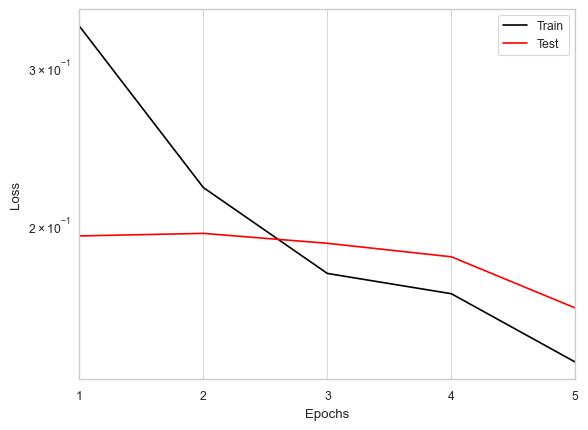

In [23]:
plot_loss_evolution(train_loss, test_loss)

### Evaluation

In [24]:
# load the best model 
model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    y_pred = model(input_val)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_val)
    print(f"Test Loss: {val_loss.item():.6f}")

Test Loss: 0.165780


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_14920\789011671.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Plotting results

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [25]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [26]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [27]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [28]:
input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, sequence_length=101)

output = model(input_tensor)
output_denorm = dataset.denormalize_output(output)
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

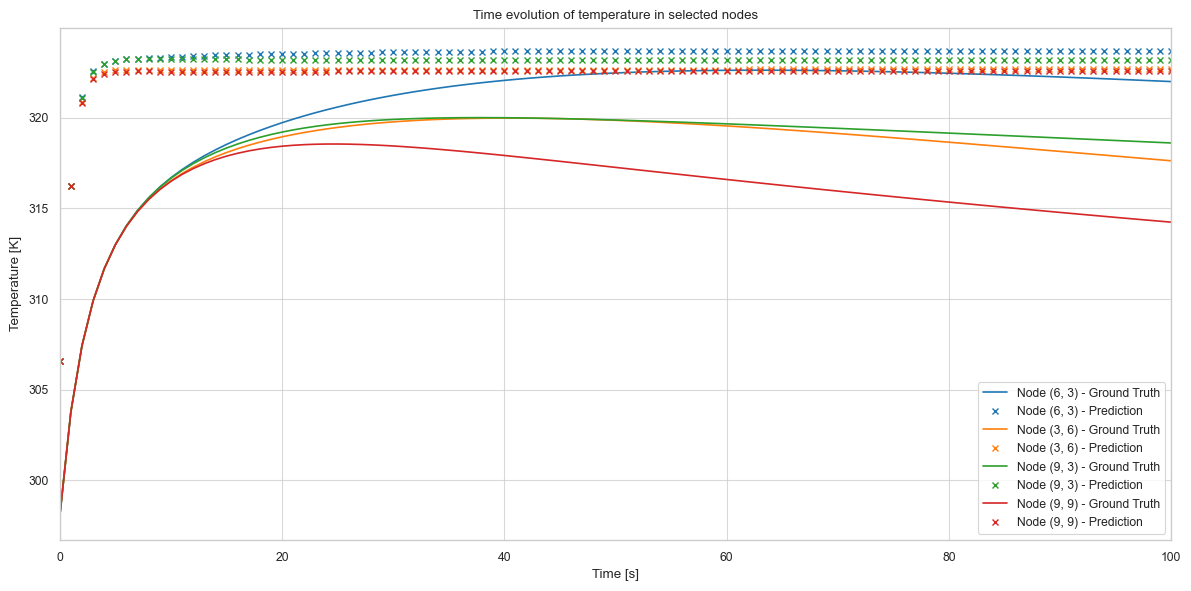

In [29]:
plot_nodes_evolution(T_pred, T, id_heaters, together=True)

## Physics informed Convolutional LSTM

In [30]:
from Physics_Loss import *

### New loss function validation

Validation of the Physics loss function

In [31]:
# Crear instancia de la clase de pérdida
physics_loss = PhysicsLossTransient().to(device)

# Parámetros
B = 1        # batch size
H = W = 13    # dimensiones espaciales

# Obtener datos reales del solver
T2, _, interfaces2, heaters2 = PCB_case_2(solver='transient', display=False, time=100, dt=1, T_init=298.0)
T = T2.shape[0]      # número de pasos temporales

# Temperatura: [B, T, 1, 13, 13]
T_tensor = torch.tensor(T2, dtype=torch.float32).view(T, 1, H, W).unsqueeze(0).repeat(B, 1, 1, 1, 1).to(device)

interfaces_input = torch.tensor([list(interfaces2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
heaters_input = torch.tensor([list(heaters2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
Tenv = torch.full((B, 1), 250.0).to(device) # [B, 1]

# Calcular la pérdida
loss = physics_loss(
    T_pred=T_tensor,
    T_true=T_tensor,
    heaters_input=heaters_input,
    interfaces_input=interfaces_input,
    Tenv=Tenv
)

# # Mostrar resultado
print(f"Physics loss (esperada ≈ 0): {loss.item():.6e}")

Physics loss (esperada ≈ 0): 2.517081e-12


Validation of the boundary loss function

In [32]:
# # Crear una instancia de BoundaryLoss con valores predeterminados
# boundary_loss = BoundaryLoss()

# # Ejemplo de tensores
# interfaces_example = torch.tensor(list(interfaces2.values()), dtype=torch.float32).unsqueeze(0)

# # Calcular la pérdida
# loss = boundary_loss(T2, interfaces_example)
# print("Pérdida en las interfaces:", loss.item())

Función para extraer las condiciones de contorno de los tensores de los 3 canales

In [33]:
def extract_boundary_conditions_from_dataset(input_tensor, dataset: PCBDataset, nodes_side=13):
    """
    Extrae las condiciones de contorno originales (desnormalizadas) a partir de un input_tensor y el dataset asociado.
    input_tensor: tensor de forma [batch, sequence_length, 3, nodes_side, nodes_side]
    """
    input_0 = input_tensor[0, 0]  # [3, 13, 13]

    T_interfaces1 = input_0[0]
    Q_heaters1 = input_0[1]
    T_env1 = input_0[2]

    # Extraer los valores originales usando los métodos de desnormalización del dataset
    T_interfaces_raw = torch.tensor([
        T_interfaces1[0, 0],
        T_interfaces1[0, nodes_side - 1],
        T_interfaces1[nodes_side - 1, nodes_side - 1],
        T_interfaces1[nodes_side - 1, 0]
    ], device=input_tensor.device)
    T_interfaces_in = dataset.denormalize_T_interfaces(T_interfaces_raw)

    Q_heaters_raw = torch.tensor([
        Q_heaters1[6, 3],
        Q_heaters1[3, 6],
        Q_heaters1[9, 3],
        Q_heaters1[9, 9]
    ], device=input_tensor.device)
    Q_heaters_in = dataset.denormalize_Q_heaters(Q_heaters_raw)

    T_env_in = dataset.denormalize_T_env(T_env1[0, 0])

    return Q_heaters_in, T_interfaces_in, T_env_in


def extract_all_boundary_conditions(input_tensor, dataset: PCBDataset, nodes_side=13):
    """
    Extrae las condiciones de contorno desnormalizadas de todos los ejemplos del batch.
    Retorna tres listas: Q_heaters_all, T_interfaces_all, T_env_all.
    """
    batch_size = input_tensor.shape[0]
    Q_heaters_all = []
    T_interfaces_all = []
    T_env_all = []

    for i in range(batch_size):
        q, t_int, t_env = extract_boundary_conditions_from_dataset(input_tensor[i:i+1], dataset, nodes_side)
        Q_heaters_all.append(q)
        T_interfaces_all.append(t_int)
        T_env_all.append(t_env)

    Q_heaters_all = torch.stack(Q_heaters_all)       # [batch_size, 4]
    T_interfaces_all = torch.stack(T_interfaces_all) # [batch_size, 4]
    T_env_all = torch.stack(T_env_all)               # [batch_size]

    return Q_heaters_all, T_interfaces_all, T_env_all


In [34]:
# Q_heaters_train, T_interfaces_train, T_env_train = extract_all_boundary_conditions(input_train, dataset_train)
# Q_heaters_test, T_interfaces_test, T_env_test = extract_all_boundary_conditions(input_test, dataset_test)
# Q_heaters_validation, T_interfaces_validation, T_env_validation = extract_all_boundary_conditions(input_validation, dataset_validation)

# DEBUGGING
# print("Q_heaters_all.shape:", Q_heaters_train.shape)
# print("T_interfaces_all.shape:", T_interfaces_train.shape)
# print("T_env_all.shape:", T_env_train.shape)

# # Ejemplo del primero
# print("Ejemplo 0:")
# print("Q_heaters:", Q_heaters_train[0])
# print("T_interfaces:", T_interfaces_train[0])
# print("T_env:", T_env_train[0])


### Model definition

Hyperparameters of training

In [35]:
mse_weight = 1.0
phy_weight = 0.05
bnd_weight = 0.05

In [36]:
# # Función auxiliar para preparar datos (con repetición temporal)
# def prepare_data_with_bc(dataset, device):
#     inputs, outputs, q, t_int, t_env = zip(*[dataset[i] for i in range(len(dataset))])
    
#     # Convertir listas a tensores
#     outputs = torch.stack(outputs)                          # [B, T, 1, 13, 13] (incluye todos los pasos temporales)
#     inputs = torch.stack(inputs)                            # [B, 3, 13, 13] 
#     inputs = inputs.unsqueeze(1).repeat(1, outputs.shape[1], 1, 1, 1)  # [B, T, 3, 13, 13] (repetir en el tiempo)
#     q = torch.stack(q).view(len(dataset), -1)               # [B, 4]
#     t_int = torch.stack(t_int).view(len(dataset), -1)       # [B, 4]
#     t_env = torch.stack(t_env).view(len(dataset), -1)       # [B, 1]
    
#     # Asegurarse de que outputs tenga la forma correcta
#     if outputs.ndim == 4:  # Si outputs no tiene dimensión temporal
#         outputs = outputs.unsqueeze(2)                     # [B, T, 1, 13, 13]

#     # print("inputs.shape:", inputs.shape)   # DEBUGGING
#     # print("outputs.shape:", outputs.shape)  # DEBUGGING

#     # Concatenar todas las condiciones de contorno
#     bc_all = torch.cat([q, t_int, t_env], dim=1)            # [B, 9]

#     # Mover a dispositivo
#     return TensorDataset(inputs.to(device), outputs.to(device), bc_all.to(device))

In [37]:
# from Dataset_Class import PCBDataset  # Ensure the PCBDataset class is imported

# dataset_path = os.path.join(dir_path,'Datasets')

# # Allowlist the PCBDataset class for safe loading
# torch.serialization.add_safe_globals([PCBDataset])

# dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'), weights_only=True)
# dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'), weights_only=True)
# dataset_validation:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_validation.pth'), weights_only=True)

# dataset_train.return_bc = True
# dataset_test.return_bc = True
# dataset_validation.return_bc = True


# # Preparar datasets
# train_ds = prepare_data_with_bc(dataset_train, device)
# test_ds = prepare_data_with_bc(dataset_test, device)
# validation_ds = prepare_data_with_bc(dataset_validation, device)

In [38]:
from convlstm import *

class PCB_ConvLSTM_physics(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [40]:
dataset_train.base_dataset.return_bc = True
dataset_test.base_dataset.return_bc = True  

# train_ds = TensorDataset(input_train, output_train)
input_train, output_train, bc_train = prepare_data_for_convlstm(dataset_train, with_bc=dataset_train.base_dataset.return_bc)
train_loader_phy = DataLoader(TensorDataset(input_train, output_train, bc_train), batch_size=batch_size, shuffle=dataset_test.base_dataset.return_bc)
# test_ds = TensorDataset(input_test, output_test)
input_test, output_test, bc_test = prepare_data_for_convlstm(dataset_test, with_bc=dataset_test.base_dataset.return_bc)
test_loader_phy = DataLoader(TensorDataset(input_test, output_test, bc_test), batch_size=batch_size, shuffle=dataset_test.base_dataset.return_bc)

sample = next(iter(train_loader_phy))
print("   🔹 Number of items in batch:", len(sample))



model = PCB_ConvLSTM_physics(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

# Loss criterion
# criterion_reconstruction = nn.MSELoss()
# criterion_physics = PhysicsLossTransient()
# criterion_boundary = BoundaryLoss()

total_loss_fn = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=phy_weight,
    boundary_weight=bnd_weight,
    denormalize_output_fn=dataset.denormalize_output,
    # physics_params=dict(L=0.1, thickness=0.001, board_k=15),  # pon aquí los valores que usas
    # boundary_params=dict(nx=13, ny=13)
)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

# # DEBUGGING
# batch = next(iter(train_dl))
# x, y = batch

# print(f"x está en: {x.device}")
# print(f"y está en: {y.device}")
# print(f"model está en: {next(model.parameters()).device}")

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

### Training

Training and saving best model with best parameters.

In [ ]:
train_loss = []
test_loss = []
loss_mse = []
loss_phy = []
loss_bndry = []

best_test_loss = np.inf
epochs_without_improvement = 0

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
os.makedirs(model_dir, exist_ok=True)

# Nombre del archivo con hiperparámetros
filename_phy = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_lr{lr}_bs{batch_size}_h{len(hidden_dims)}_k{kernel_string}_phy_{phy_weight}_bnd{bnd_weight}.pth"

# Ruta completa del modelo
model_path_phy = os.path.join(model_dir, filename_phy)

# Comprobar si el modelo ya existe
if os.path.exists(model_path_phy):
    display(Markdown(f"**❌ El modelo `{filename_phy}` ya existe. Se omite esta celda para evitar sobreescritura.**"))
    # Detiene la ejecución de esta celda sin interrumpir el notebook
    raise SystemExit

# ruta para el JSON
json_path_phy = model_path_phy.replace('.pth', '.json')

start_time_training = time.time()
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_loss_mse = 0.0
    total_loss_phy = 0.0
    total_loss_bndry = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y, q, t_int, t_env in tqdm(train_loader_phy, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        optimizer.zero_grad()
        
        y_hat = model(x) # model prediction
        
        q_denorm     = dataset.denormalize_Q_heaters(q)
        t_int_denorm = dataset.denormalize_T_interfaces(t_int)
        t_env_denorm = dataset.denormalize_T_env(t_env)
        y_denorm     = dataset.denormalize_output(y)
        y_hat_denorm = dataset.denormalize_output(y_hat)
        
        # q = bc_all[:, 0:4] # sin normalizar
        # q_denorm = q * Q_heaters_std + Q_heaters_mean # denormalizo
        # t_int = bc_all[:, 4:8] # sin normalizar
        # t_int_denorm = t_int * T_interfaces_std + T_interfaces_mean # denormalizo
        # t_env = bc_all[:, 8].unsqueeze(1) # sin normalizar
        # t_env_denorm = t_env * T_env_std + T_env_mean # denormalizo
        
        # print(q.mean(), t_int.mean(), t_env.mean()) # DEBUGGING
        
        # y_hat_denorm = y_hat * output_std + output_mean
        # y_denorm = y * output_std + output_mean
        
        y_hat, y, y_hat_denorm, y_denorm, q_denorm, t_int_denorm, t_env_denorm = prepare_inputs_for_loss(
            y_hat, y, bc_all,
            output_mean, output_std,
            Q_heaters_mean, Q_heaters_std,
            T_interfaces_mean, T_interfaces_std,
            T_env_mean, T_env_std
        )
        
        
        # print("y_hat.shape:", y_hat.shape, "y.shape:", y.shape, "x.shape", x.shape) # DEBUGGING
        
        # loss_reconstruction = criterion_reconstruction(y_hat, y) # sin normalizar
        # loss_physics = criterion_physics(y_hat_denorm, y_denorm, q_denorm, t_int_denorm, t_env_denorm) # denormalizados
        # loss_boundary = criterion_boundary(y_hat_denorm, t_int_denorm) # denormalizados

        # loss = loss_reconstruction + phy_param * loss_physics + bnd_param * loss_boundary
        
        
        loss, loss_mse_batch, loss_phys_batch, loss_bdry_batch = total_loss_fn(y_hat, y, q_denorm, t_int_denorm, t_env_denorm)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
        total_loss_mse += loss_mse_batch.item()
        total_loss_phy += loss_phys_batch.item()
        total_loss_bndry += loss_bdry_batch.item()
        
    epoch_train_loss = total_loss / len(train_loader_phy)
    epoch_loss_mse = total_loss_mse / len(train_loader_phy)
    epoch_loss_phy = total_loss_phy / len(train_loader_phy)
    epoch_loss_bndry = total_loss_bndry / len(train_loader_phy)
    
    train_loss.append(epoch_train_loss)
    loss_mse.append(epoch_loss_mse)
    loss_phy.append(epoch_loss_phy)
    loss_bndry.append(epoch_loss_bndry)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test, bc_test in test_loader_phy:
            
            # q = bc_test[:, 0:4]
            # q_denorm = q * Q_heaters_std + Q_heaters_mean
            # t_int = bc_test[:, 4:8]
            # t_int_denorm = t_int * T_interfaces_std + T_interfaces_mean
            # t_env = bc_test[:, 8].unsqueeze(1)
            # t_env_denorm = t_env * T_env_std + T_env_mean
            
            y_pred = model(x_test)
            # y_pred_denorm = y_pred * output_std + output_mean
            # y_test_denorm = y_test * output_std + output_mean
            
            # loss_test_reconstruction = criterion_reconstruction(y_pred, y_test)
            # loss_test_physics = criterion_physics(y_pred_denorm, y_test_denorm, q_denorm, t_int_denorm, t_env_denorm)
            # loss_test_boundary = criterion_boundary(y_pred_denorm, t_int_denorm)
            y_pred, y_test, y_pred_denorm, y_test_denorm, q_denorm, t_int_denorm, t_env_denorm = prepare_inputs_for_loss(
                y_pred, y_test, bc_test,
                output_mean, output_std,
                Q_heaters_mean, Q_heaters_std,
                T_interfaces_mean, T_interfaces_std,
                T_env_mean, T_env_std
            )
            
            test_loss_comb, _, _, _ = total_loss_fn(y_pred, y_test, q_denorm, t_int_denorm, t_env_denorm)
            total_test_loss += test_loss_comb.item()            
            # total_test_loss += test.item()

    epoch_test_loss = total_test_loss / len(test_loader_phy)
    test_loss.append(epoch_test_loss)
    
    # Scheduler update
    scheduler.step(epoch_test_loss)
    
    elapsed_minutes = (time.time() - start_time_training) / 60
    
    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        
        # Guardar el modelo
        torch.save(model.state_dict(), model_path_phy)
        
        current_lr = optimizer.param_groups[0]['lr']       
    
        # Guardar hiperparámetros en JSON  
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
            "physics": {
                "phy_param": phy_weight,
                "bnd_param": bnd_weight,
            }
        }
        
        with open(json_path_phy, 'w') as f:
            json.dump(params, f, indent=4)
    
        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")
        
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")
    
print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

ValueError: not enough values to unpack (expected 5, got 4)

Plotting validation loss and train loss

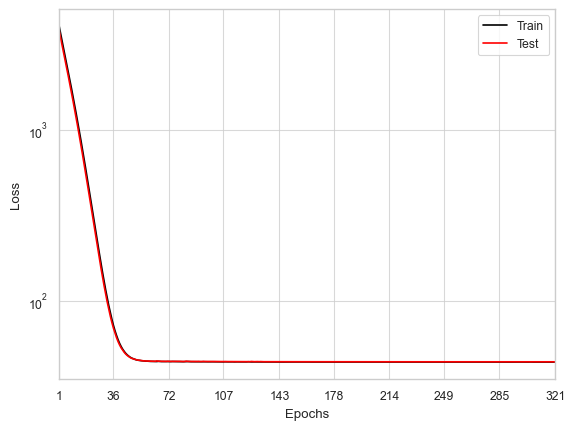

In [ ]:
plot_loss_evolution(train_loss, test_loss)

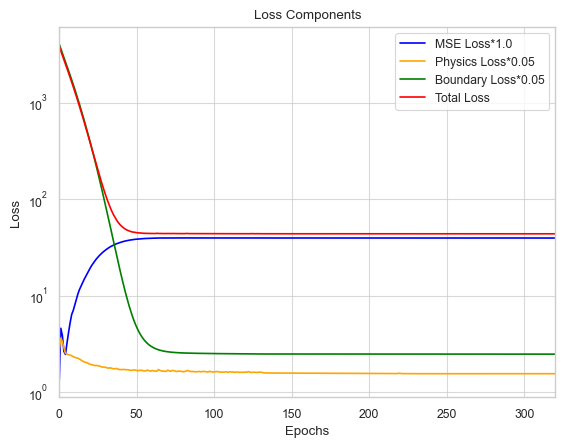

In [ ]:
# Ensure loss_phy and loss_bndry are converted to NumPy arrays for element-wise multiplication
loss_mse = np.array(loss_mse)
loss_phy = np.array(loss_phy)
loss_bndry = np.array(loss_bndry)

plt.plot(loss_mse * mse_weight, label=f'MSE Loss*{mse_weight}', color='blue')
plt.plot(loss_phy * phy_weight, label=f'Physics Loss*{phy_weight}', color='orange')
plt.plot(loss_bndry * bnd_weight, label=f'Boundary Loss*{bnd_weight}', color='green')
plt.plot(test_loss, label='Total Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, len(train_loss)-1)
plt.yscale('log')
plt.legend()
plt.title('Loss Components')
plt.show()


### Evaluation

In [ ]:
# load the best model 
model = PCB_ConvLSTM_physics(input_channels=3, hidden_dim=hidden_layers, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path_phy))
model.eval()

criterion = nn.MSELoss() # para comparar colo con la recostrucción

with torch.no_grad():
    y_pred = model(input_validation)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_validation)
    print(f"Test Loss: {val_loss.item():.6f}")

Test Loss: 39.955589


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11184\1478099081.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_phy))


### Plotting results

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [ ]:
input = get_input(Q_heaters, T_interfaces, T_env)

output = model(input)
output_denorm = output*output_std + output_mean
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

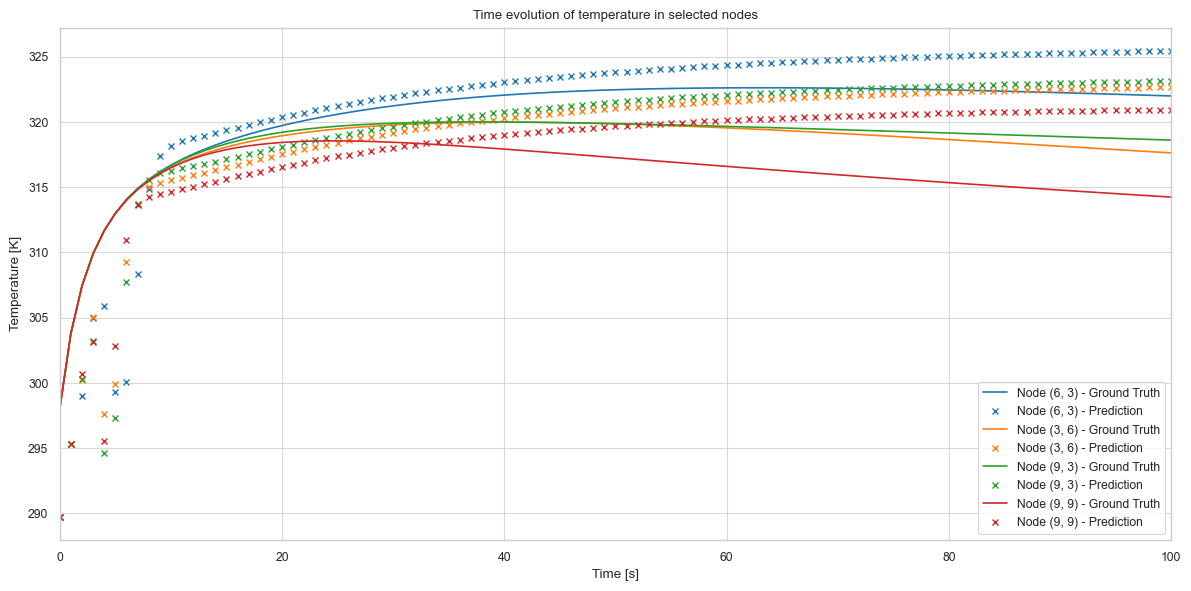

In [ ]:
plot_nodes_evolution(T_pred, T, id_heaters, together=True)

Error en la predicción

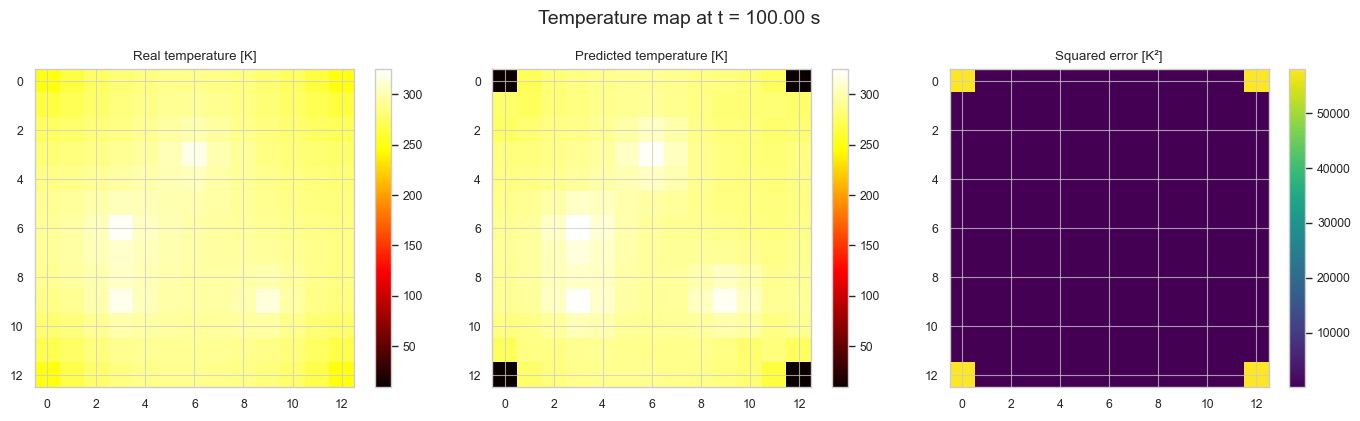

MSE: 1390.59725260 K^2


In [ ]:
plot_se_map(T_pred, T, time=100, show_pred=True)

Error en la predicción

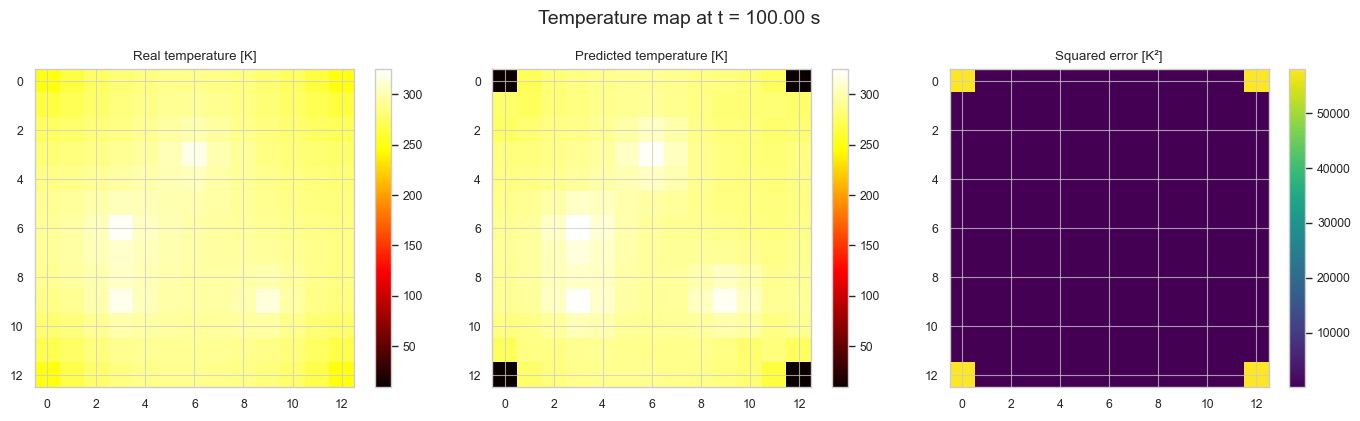

MSE: 1390.59725260 K^2


In [ ]:
plot_se_map(T_pred, T, time=100, show_pred=True)

## Comparison of models

Loading models

In [ ]:
model = PCB_ConvLSTM(input_channels=3, hidden_dim=hidden_layers, kernel_size=kernel_size, height=13, width=13).to(device)
model_phy = PCB_ConvLSTM_physics(input_channels=3, hidden_dim=hidden_layers, kernel_size=kernel_size, height=13, width=13).to(device)

model.load_state_dict(torch.load(model_path))
model.to(device).eval()
model_phy.load_state_dict(torch.load(model_path_phy))
model_phy.to(device).eval()
print(f"Modelos cargados en dispositivo {device} y listos para evaluar.")

Modelos cargados en dispositivo cuda y listos para evaluar.


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11184\2926254028.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\User

Generating random data to evaluate the models

In [ ]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input = get_input(Q_random, T_interfaces_random, T_env_random)

T_true = PCB_case_2(solver='transient', display=False, time=100, dt=1, T_init=298.0, Q_heaters=Q_random, T_interfaces=T_interfaces_random, Tenv=T_env_random)[0]
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_pred = model(input).cpu().detach().numpy()[0,:,0,:,:]
T_pred_phy = model_phy(input).cpu().detach().numpy()[0,:,0,:,:]
# T_pred.shape, T_pred_phy.shape, T_true.shape

Error calculation

In [ ]:
error = T_true - T_pred
error_phy = T_true - T_pred_phy

error_last = error[-1]
error_phy_last = error_phy[-1]

Non-PINN

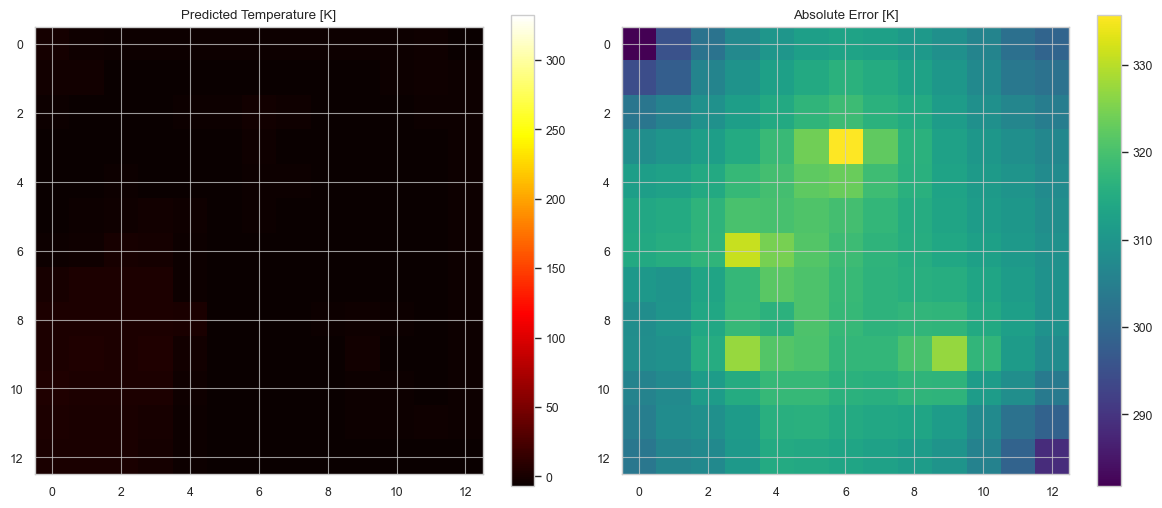

In [ ]:
plot_prediction_and_error(T_pred, T_true, t=100, cmap='hot', save_as_pdf=False, filename='prediction_and_error')

PINN

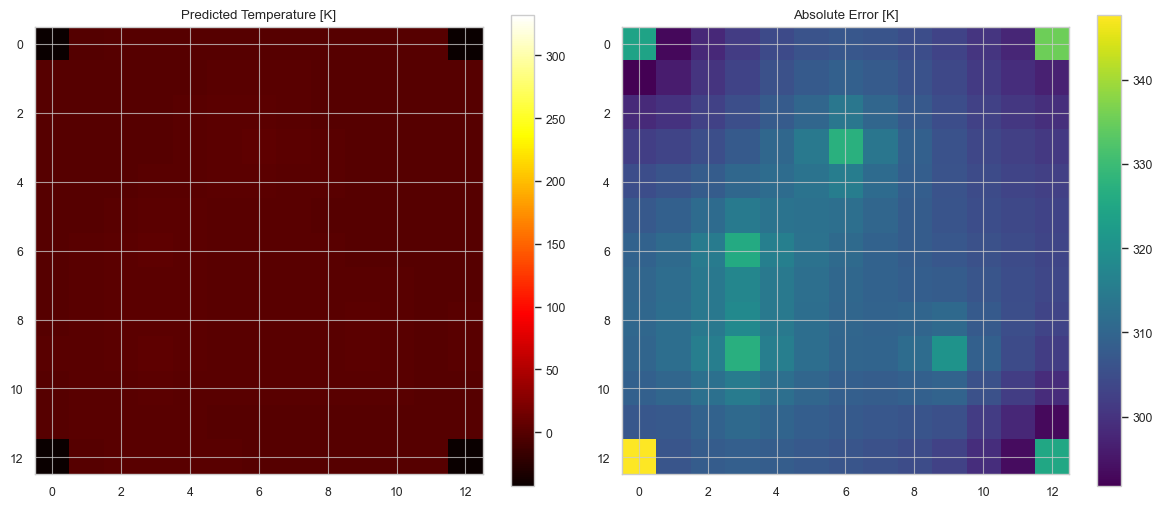

In [ ]:
plot_prediction_and_error(T_pred_phy, T_true, t=-1, cmap='hot', save_as_pdf=False, filename='prediction_and_error')

Error plot comparison

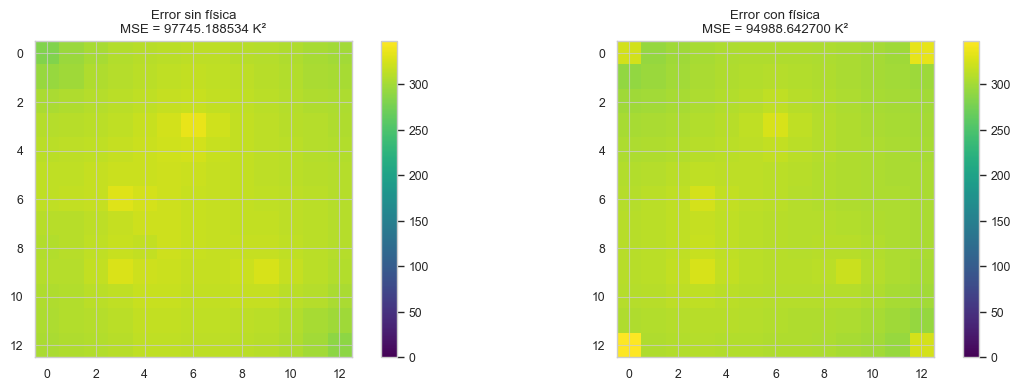

In [ ]:
compare_error_maps_2d(error_last, error_phy_last, ("Error sin física", "Error con física"), save_as_pdf=True)